## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)


---

## Task 1: Introduction


## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [4]:
%matplotlib inline

import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.12.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [5]:
import pandas as pd

dataset = pd.read_pickle(r"E:\College\Sem 6\Mini Project\dataset\merged_training.pkl")


In [6]:
dataset.head()

,text,emotions
27383,i feel awful about it too because it s my job ...,sadness
110083,im alone i feel awful,sadness
140764,ive probably mentioned this before but i reall...,joy
100071,i was feeling a little low few days back,sadness
2837,i beleive that i am much more sensitive to oth...,love


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split



# Split the dataset into train, validation, and test sets
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Split into train and remaining data
train_val_df, test = train_test_split(dataset, test_size=test_ratio, random_state=42)

# Split train_val_df into train and validation sets
train, val = train_test_split(train_val_df, test_size=val_ratio/(train_ratio+val_ratio), random_state=42)

# Rename the dataframes using a dictionary
dataframes = {
    'train': train,
    'val': val,
    'test': test
}

# Print the shapes of the resulting sets
for name, df in dataframes.items():
    print(f"{name} set shape:", df.shape)


train set shape: (333447, 2)
val set shape: (41681, 2)
test set shape: (41681, 2)


In [8]:
def get_tweets(data):
    tweets = data['text'].tolist()
    labels = data['emotions'].tolist()
    return tweets, labels


In [9]:
tweets, labels = get_tweets(train)

In [10]:
tweets[0], labels[0]

('i i feel as if no one wants to bring up secretary clinton or even before he resigned david petraeus because frankly they are seen as so popular in the nation s capital',
 'sadness')

## Task 4: Tokenizer

1. Tokenizing the tweets

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [12]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')

tokenizer.fit_on_texts(tweets)

print(tokenizer.texts_to_sequences([tweets[0]]))

[[2, 2, 3, 29, 52, 97, 68, 869, 5, 784, 42, 7977, 8865, 35, 74, 167, 65, 1307, 2637, 1, 37, 2058, 63, 46, 823, 29, 15, 564, 12, 6, 3003, 84, 5918]]


In [13]:
#SAVE THE STATE OF TOKENIZER
import pickle

# Save the tokenizer to a file
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

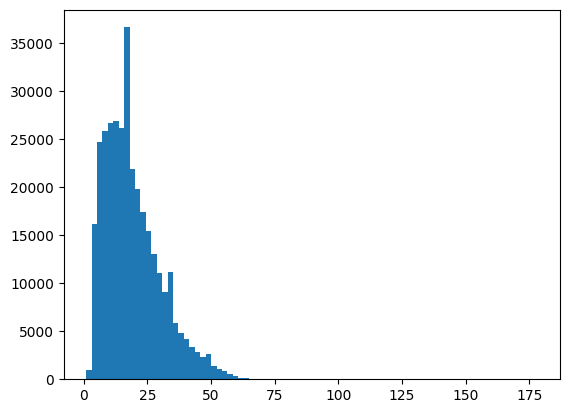

In [14]:
lengths = [len(t.split(' ')) for t in tweets]

plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [16]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=50, padding='post')
    return padded_sequences

In [17]:
padded_train_sequences = get_sequences(tokenizer, tweets)

In [18]:
padded_train_sequences[0]

array([   2,    2,    3,   29,   52,   97,   68,  869,    5,  784,   42,
       7977, 8865,   35,   74,  167,   65, 1307, 2637,    1,   37, 2058,
         63,   46,  823,   29,   15,  564,   12,    6, 3003,   84, 5918,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0])

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [19]:
classes = set(labels)
print(classes)

{'fear', 'joy', 'anger', 'surprise', 'love', 'sadness'}


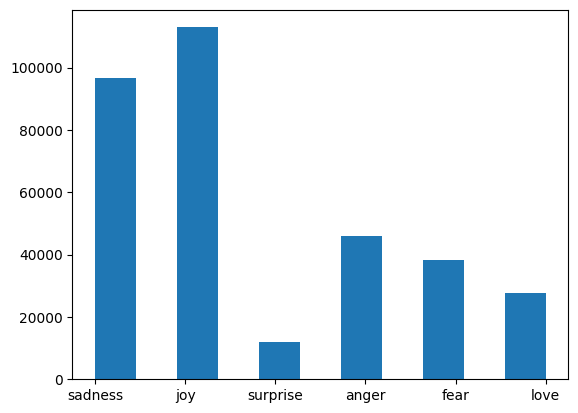

In [20]:
plt.hist(labels, bins=11)
plt.show()

In [21]:
emotion_sequence = ['anger', 'fear', 'sadness', 'surprise', 'joy', 'love']

classes_to_index = {c: i for i, c in enumerate(emotion_sequence)}
index_to_classes = {i: c for i, c in enumerate(emotion_sequence)}


In [22]:
classes_to_index

{'anger': 0, 'fear': 1, 'sadness': 2, 'surprise': 3, 'joy': 4, 'love': 5}

In [23]:
index_to_classes

{0: 'anger', 1: 'fear', 2: 'sadness', 3: 'surprise', 4: 'joy', 5: 'love'}

In [24]:
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [25]:
train_labels = names_to_ids(labels)
print(train_labels[0])

2


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [26]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=50),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [27]:
val_tweets, val_labels = get_tweets(val)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [28]:
val_tweets[0], val_labels[0]

('i have begun the summer feeling rather dull and like a failure without real reason',
 2)

In [29]:
h = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
10421/10421 [==============================] - 472s 45ms/step - loss: 0.3000 - accuracy: 0.8799 - val_loss: 0.1249 - val_accuracy: 0.9318
Epoch 2/20
10421/10421 [==============================] - 422s 41ms/step - loss: 0.1103 - accuracy: 0.9359 - val_loss: 0.1015 - val_accuracy: 0.9365
Epoch 3/20
10421/10421 [==============================] - 418s 40ms/step - loss: 0.0958 - accuracy: 0.9395 - val_loss: 0.0969 - val_accuracy: 0.9366
Epoch 4/20
10421/10421 [==============================] - 419s 40ms/step - loss: 0.0909 - accuracy: 0.9414 - val_loss: 0.0963 - val_accuracy: 0.9373
Epoch 5/20
10421/10421 [==============================] - 392s 38ms/step - loss: 0.0886 - accuracy: 0.9418 - val_loss: 0.0947 - val_accuracy: 0.9375
Epoch 6/20
10421/10421 [==============================] - 425s 41ms/step - loss: 0.0864 - accuracy: 0.9428 - val_loss: 0.0965 - val_accuracy: 0.9378
Epoch 7/20
10421/10421 [==============================] - 427s 41ms/step - loss: 0.0846 - accuracy: 0.9430

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

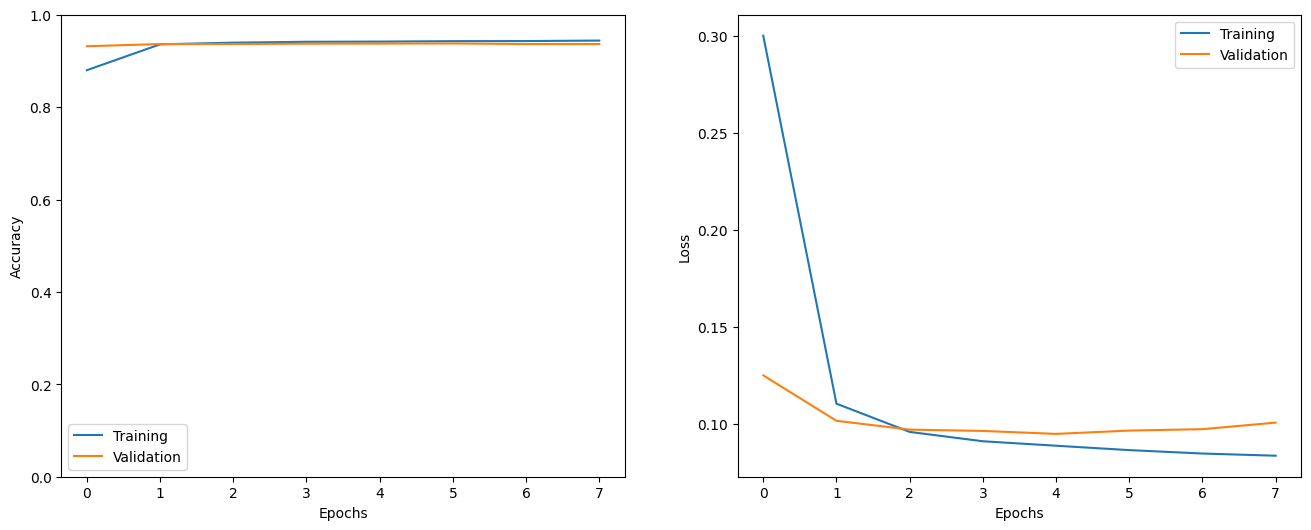

In [30]:
show_history(h)

In [31]:
# Save the trained model
model.save("emotion_model_trained.h5")

In [32]:
test_tweets, test_labels = get_tweets(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [33]:
_ = model.evaluate(test_sequences, test_labels) 

1303/1303 [==============================] - 13s 10ms/step - loss: 0.0986 - accuracy: 0.9381


In [113]:
# Generate a random index
i = random.randint(0, len(test_labels) - 1)

# Get the random sentence and its corresponding emotion label
sentence = test_tweets[i]
true_emotion = index_to_classes[test_labels[i]]

# Predict the top 3 emotions using the model
predictions = model.predict(np.expand_dims(test_sequences[i], axis=0))
top_indices = np.argsort(predictions, axis=1)[0, -3:][::-1]  # Get the indices of top 3 probabilities in descending order
top_emotions = [index_to_classes[idx] for idx in top_indices]  # Convert indices to corresponding emotions

# Print the results
print('RANDOM SENTENCE:', sentence)
print('TRUE EMOTION:', true_emotion)
print('TOP 3 PREDICTED EMOTIONS:')
for emotion, prob in zip(top_emotions, predictions[0, top_indices]):
    formatted_prob = '{:.3f}'.format(prob)  # Format probability with 3 decimal places
    print(emotion, '- Probability:', formatted_prob)

# Rest of the code...


1/1 [==============================] - 0s 27ms/step
RANDOM SENTENCE: i feel so helpless and useless all the time and i always doubt myself
TRUE EMOTION: sadness
TOP 3 PREDICTED EMOTIONS:
fear - Probability: 0.593
sadness - Probability: 0.405
anger - Probability: 0.002


In [86]:
# Get the predicted probabilities for each class
pred_probs = model.predict(test_sequences)

# Find the class with the highest probability for each prediction
preds = np.argmax(pred_probs, axis=1)

# Print the shapes of the prediction and label arrays
print('Prediction shape:', preds.shape)
print('Label shape:', test_labels.shape)


1303/1303 [==============================] - 13s 10ms/step
Prediction shape: (41681,)
Label shape: (41681,)


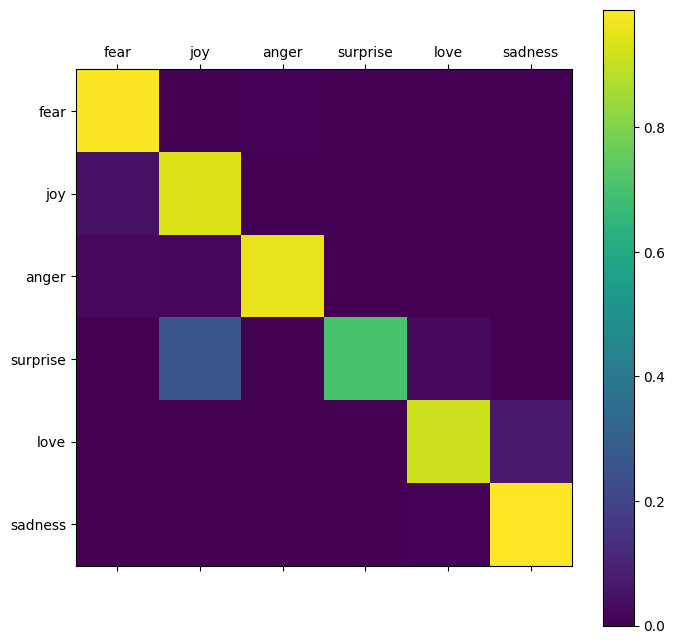

In [97]:
show_confusion_matrix(test_labels, preds, list(classes))